## Moving Average 

- Math 
- Codes 
- Model development 
- Coeefficinets and Log-likelihood 
- Residuals 
- Lags
- Check on Non-Stationar data 


**Simple MA (Moving Average) Mode**

$
r_t = C + \theta_1 \times \epsilon_{t-1} + \epsilon_t
$

- $ r_t$ - The value of $r$ in current period. 
- $\theta_1$ - A numeric coefficient for the value associated with the first lag
- $\epsilon_t$ - Residualss 
- $\epsilon_{t-1}$ - Previous residuals 


**Compute $\epsilon$**

$\epsilon_t$ = $Actual_t -Predicted_t$


**AR vs MA**

we can say a simple MA model is equivalent to an infinite AR model with certain restrictions, and inverse relation exists. An AR model uses the value of the variable while the model relies on the residual. To determine the number of lags, we relied on PACF, and ACF for MA models. The reason is the MA models aren't based on past period returns, therefore, determining which lagged values have a significant direct effect on the present day ones is not relevant.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
from math import sqrt
sns.set()


Primary preprocessing 

In [2]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv")
df = raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index("date", inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')


In [3]:
# picking market value for FTSE
df['market_value'] = df.ftse

df.drop(["spx", "ftse", "nikkei", "dax"], axis=1, inplace=True)
df.describe()


,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


Split the data 

In [4]:
train_locs = int(df.shape[0]*0.8)
train_locs


5021

In [5]:
df, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df, df_test


(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

**LLR Test**

In [6]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p

Creating returns 

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

**ACF Returns** 

It gives us an idea to how many lags we should use in our model.

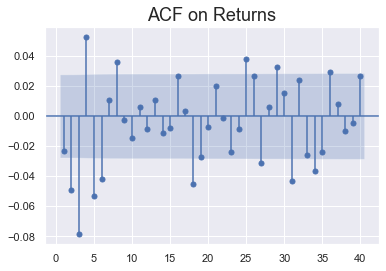

In [8]:
sgt.plot_acf(df.returns[1:], zero=False, lags=40)
plt.title("ACF on Returns", size=18)
plt.show()

### MA (1) for Returns

In [9]:
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0,0,1))
result_ret_ma_1 = model_ret_ma_1.fit()
result_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Fri, 19 Aug 2022   AIC                          15865.190
Time:                        10:41:30   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can notice that the coefficient for the one lag ago residual is significant at the 10 percent level, but not at the five percent level. This shouldn't come as a surprise since the first coefficient of the ACF was also not significantly different from zero. However, all other coefficients up to six lags ago fell outside the blue area, which suggests significance. In addition, the 8th and the 18th lags, we're also significant, as were some others, more than 20 periods ago. Since we expect the compound effects to decrease the further back in time we go, we can disregard the 18th lag and all significant periods that follow it.


**Lets go higher lags for MA model**

In [10]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0,0,2))
result_ret_ma_2 = model_ret_ma_2.fit()
result_ret_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Fri, 19 Aug 2022   AIC                          15853.728
Time:                        10:41:31   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.000      -0.066      -0.035
sigma2         1.3753      0.014     99.021      0.000       1.348       1.402
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7657.23
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
llr_test(model_ret_ma_1, model_ret_ma_2)

0.0

What we notice is that the p value for the error term two periods ago is significant, which is expected from our ACF plot. However, you can see the p value for the one period ago, residual is now also significant. The MA (2) results and LLR test decide that the MA(2) model is better than MA(1)

In [12]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0,0,3))
result_ret_ma_3 = model_ret_ma_3.fit()
result_ret_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Fri, 19 Aug 2022   AIC                          15818.634
Time:                        10:41:33   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.000      -0.071      -0.040
ma.L3         -0.0904      0.008    -11.594      0.000      -0.106      -0.075
sigma2         1.3651      0.014     95.367      0.000       1.337       1.393
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              6843.07
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=(0,0,6))
result_ret_ma_6 = model_ret_ma_6.fit()
result_ret_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Fri, 19 Aug 2022   AIC                          15794.442
Time:                        10:56:47   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.000      -0.064      -0.033
ma.L3         -0.0827      0.008    -10.179      0.000      -0.099      -0.067
ma.L4          0.0466      0.009      5.386      0.000       0.030       0.064
ma.L5         -0.0484      0.008     -5.991      0.000      -0.064      -0.033
ma.L6         -0.0387      0.009     -4.318      0.000      -0.056      -0.021
sigma2         1.3569      0.015     92.179      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6533.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=(0,0,7))
result_ret_ma_7 = model_ret_ma_7.fit()
result_ret_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Fri, 19 Aug 2022   AIC                          15796.091
Time:                        10:41:35   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.000      -0.065      -0.033
ma.L3         -0.0821      0.008     -9.988      0.000      -0.098      -0.066
ma.L4          0.0458      0.009      5.292      0.000       0.029       0.063
ma.L5         -0.0486      0.008     -5.989      0.000      -0.064      -0.033
ma.L6         -0.0390      0.009     -4.314      0.000      -0.057      -0.021
ma.L7          0.0085      0.009      0.947      0.343      -0.009       0.026
sigma2         1.3568      0.015     91.390      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6506.02
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model_ret_ma_8 = ARIMA(df.returns[1:], order=(0,0,8))
result_ret_ma_8 = model_ret_ma_8.fit()
result_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Fri, 19 Aug 2022   AIC                          15791.205
Time:                        10:57:15   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.000      -0.066      -0.033
ma.L3         -0.0847      0.008    -10.308      0.000      -0.101      -0.069
ma.L4          0.0488      0.009      5.615      0.000       0.032       0.066
ma.L5         -0.0518      0.008     -6.304      0.000      -0.068      -0.036
ma.L6         -0.0402      0.009     -4.411      0.000      -0.058      -0.022
ma.L7          0.0083      0.009      0.938      0.348      -0.009       0.026
ma.L8          0.0365      0.009      3.881      0.000       0.018       0.055
sigma2         1.3550      0.015     91.305      0.000       1.326       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6440.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model_ret_ma_9 = ARIMA(df.returns[1:], order=(0,0,9))
result_ret_ma_9 = model_ret_ma_9.fit()
result_ret_ma_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -7885.457
Date:                Fri, 19 Aug 2022   AIC                          15792.914
Time:                        10:41:38   BIC                          15864.648
Sample:                    01-10-1994   HQIC                         15818.051
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.255      0.209      -0.011       0.048
ma.L1         -0.0242      0.009     -2.565      0.010      -0.043      -0.006
ma.L2         -0.0494      0.008     -6.015      0.000      -0.066      -0.033
ma.L3         -0.0847      0.008    -10.255      0.000      -0.101      -0.069
ma.L4          0.0492      0.009      5.650      0.000       0.032       0.066
ma.L5         -0.0523      0.008     -6.351      0.000      -0.068      -0.036
ma.L6         -0.0397      0.009     -4.354      0.000      -0.058      -0.022
ma.L7          0.0090      0.009      1.008      0.313      -0.008       0.026
ma.L8          0.0366      0.009      3.886      0.000       0.018       0.055
ma.L9         -0.0080      0.009     -0.877      0.381      -0.026       0.010
sigma2         1.3549      0.015     90.784      0.000       1.326       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6468.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the MA(9) model produces a non significant coefficient and fails the test. This is exactly shown in ACF.

#### Residuals for returns 

In [15]:
df['res_rest_ma_9'] = result_ret_ma_9.resid[1:]

In [16]:
round(df.res_rest_ma_9.mean(),3)


-0.0

In [17]:
round(df.res_rest_ma_9.var(),3)


1.355

In [22]:
# standard deviation
round(sqrt(df.res_rest_ma_9.var()),3)

1.164

The results we get are a mean of 0.0 and a variance of 1.356. Since variance is squared standard deviation, we can determine a standard deviation of 1.164. Gaussian white noise implies normality so we can use the 68, 95, 99.7 rule (Normality). This dictates what part of the data is spread within one, two and three standard deviations from the mean in either direction. Thus, we expect that most return residuals will be between -3.5 and 3.5. This means that worst case scenario, we could be up to 7 percentage points off when predicting
the returns for a market index. Of course, this is far from ideal, since 7 percent can make all the difference when it comes to profits and losses.

**Lets examine the Residual plot**

Whether it resembles a white noise or not !!

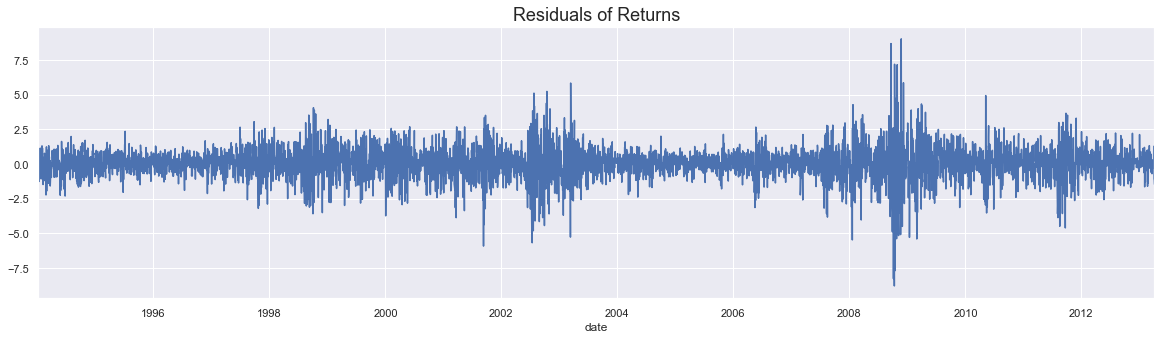

In [18]:
df.res_rest_ma_9.plot(figsize=(20, 5))
plt.title('Residuals of Returns', size=18)
plt.show()


if the data is non stationary, it can't be considered white noise. Thus we run the adjusted Deqi fuller test.

In [19]:
sts.adfuller(df.res_rest_ma_9[2:])

(-70.81102761073795,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15683.698674504669)

It is indeed stationary, p-value is 0.0. Even though we got our desired result from the test, stationary is not the same as white noise. So we should also examine the ACF of the residuals.

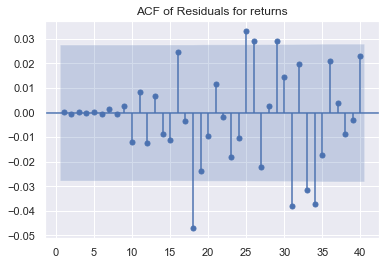

In [20]:
sgt.plot_acf(df.res_rest_ma_9[2:], zero=False, lags=40)
plt.title("ACF of Residuals for returns")
plt.show()


After running the plot ACF method, we can see that most of the coefficients are not significant.In particular, none of the first 17 lags are significant. The first eight of them are incorporated into the model, so it's not surprising they are essentially zero. However, the following nine lags are also insignificant, and this is a testament to how well our model performs. The further back in time we go, the less relevant the values and the errors become. Hence, significant coefficients, some 18 lags ago shouldn't play a major role in estimations.
This stems from the fact that markets adjust to shocks so values far in the past lose relevance.

### Normalized Returns 

In [25]:
benchmark_returns = df.returns.iloc[1]
df['norm_returns'] = df.returns.div(benchmark_returns).mul(100)

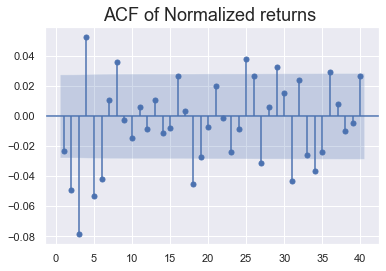

In [26]:
sgt.plot_acf(df.norm_returns[1:], zero=False, lags=40)
plt.title("ACF of Normalized returns ", size= 18)
plt.show()

We see that it is extremely similar to the one we got for the non normalized values.By observing which points fall outside the blue area, we get an idea of which lags to include. By looking at MA 6, and MA 8, we have the almost identical resutls with non-nomrlized data. Hence, Normalizing the input data does not affect the model selection. Let verify further more, whether MA(8) is a best choice or not by lloking at the residuals.

In [29]:
df['resid_norm_ret_ma_8'] = result_ret_ma_8.resid[1:]

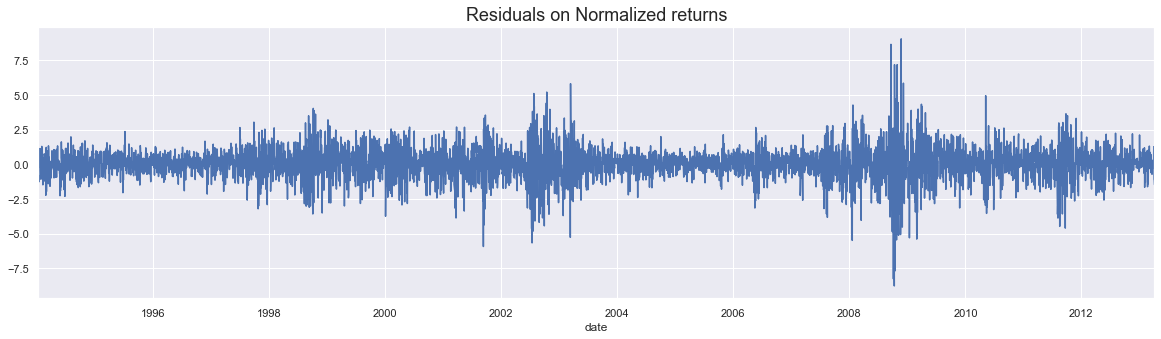

In [30]:
df.resid_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals on Normalized returns", size=18)
plt.show()

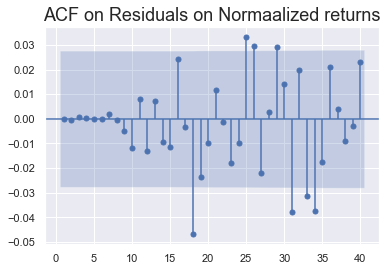

In [32]:
sgt.plot_acf(df.resid_norm_ret_ma_8[2:], zero=False, lags=40)
plt.title("ACF on Residuals on Normaalized returns", size=18)
plt.show()

The ACF suggests that the data resembles white noise, so our model choice is supposedly correct.

### MA on Non-Stationary Data

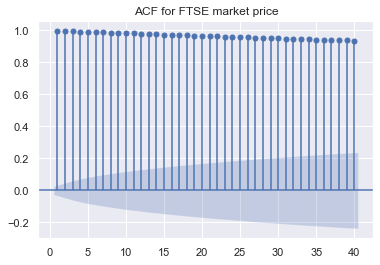

In [33]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title("ACF for FTSE market price")
plt.show()

Sadly, the coefficients for all 40 lags seem to be significant. This suggests that any higher lag model would be preferred to any lower lag one. This leads us to believe that we'd have to use an infinite model to fit this data. Since no such thing exists, it seems that no moving average model would be a good estimate of prices. But before we completely discredit this result, let's try to fit several MA models for prices and examine their resutls. 

In [34]:
market_model_ma= ARIMA(df.market_value, order=(0,0,1))
res_market_model_ma = market_model_ma.fit()
res_market_model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38629.000
Date:                Fri, 19 Aug 2022   AIC                          77264.000
Time:                        11:21:06   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6317     15.834    321.441      0.000    5058.598    5120.665
ma.L1          0.9573      0.004    231.410      0.000       0.949       0.965
sigma2      2.817e+05   8160.538     34.519      0.000    2.66e+05    2.98e+05
===================================================================================
Ljung-Box (L1) (Q):                4221.10   Jarque-Bera (JB):               291.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that both the constant and the MA one coefficient are significant. Furthermore, we see that the one lag moving average parameter is equal to 0.9573. This is incredibly close to one, which means our model tries to keep almost the entire magnitude of the error term from the last period. One way to interpret this is that each time the model tries to predict a value, it actually tries to maximize on the error from the last time. Since this is a simple model with only one lag, the error term contains all the information from the other lags.

**MA one model where all the coefficients are extremely close to one is just an approximation of an AR and model, which only takes the error term from N periods back**

### Conclusion

MA models do not perform well on non-stationary data too. But, We mentioned that the MA models were great for Random walks because they consider our mistakes.

Well, The moving average aspect of models does that, however, to actually do a decent job at modeling a non stationary process, a model should also use the previous periods values as a sort of diving board. Hence,the combination of AR and MA models woluld be best.


**Past values and Errors**

MA resulted in some correct predictions, but the residuals did not fully resemble white noise. Since we reached this exact same outcome using AR models, it seems like neither type is
sufficient to predict price returns well, not on its own at least.

- AR: Good prediction, But failed to quickly adjust the unexpected shocks, where MA smooth out the predictions
- MA: Need a baseline 

Hence, Combination of AR and MA (ARIMA) to address the issue. Please look at the ARIMA Section.